In [1]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
import sys
sys.path.insert(1, "../python/functions")
sys.path.insert(2, "../python/architecture")

In [2]:
from data_prep_functions import mnist_prep
from model_functions import *
from plotting_functions import *
import no_gpu
import reproducible

In [3]:
import time

In [4]:
X_train, X_val, y_train, y_val = mnist_prep()

In [5]:
# use samller dataset for increased speed
X_train_small = X_train[:1000, :]
X_val_small = X_val[:500, :]
y_train_small = y_train[:1000]
y_val_small = y_val[:500]

n_cols = X_train_small.shape[1]

Epoch 1/5
10/10 [==============================] - 0s 17ms/step - loss: 2.1568 - accuracy: 0.2940 - val_loss: 1.7982 - val_accuracy: 0.5340
Epoch 2/5
10/10 [==============================] - 0s 5ms/step - loss: 1.4155 - accuracy: 0.6480 - val_loss: 1.1691 - val_accuracy: 0.6720
Epoch 3/5
10/10 [==============================] - 0s 5ms/step - loss: 0.8097 - accuracy: 0.7850 - val_loss: 0.7404 - val_accuracy: 0.7840
Epoch 4/5
10/10 [==============================] - 0s 5ms/step - loss: 0.4288 - accuracy: 0.8910 - val_loss: 0.5924 - val_accuracy: 0.8240
Epoch 5/5
10/10 [==============================] - 0s 5ms/step - loss: 0.2212 - accuracy: 0.9490 - val_loss: 0.4954 - val_accuracy: 0.8440
Overall calculation took 0.7360885143280029 seconds.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________

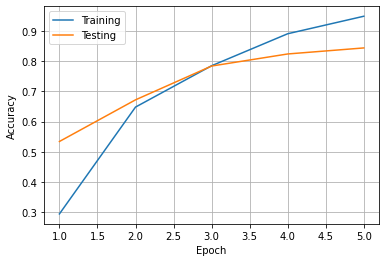

In [6]:
model = nn_model_structure(layers = 5,
                           neurons = [128, 128, 64, 32, 10],
                           n_cols = X_train_small.shape[1])
model = nn_model_compile(model)
start_time = time.time()
model = nn_model_fit(model,
                     X_train = X_train_small,
                     y_train = y_train_small,
                     X_val = X_val_small,
                     y_val = y_val_small,
                     batch_size = 100,
                     epochs = 5)
end_time = time.time()
print("Overall calculation took {} seconds.".format(end_time - start_time))
model.summary()
nn_plot_acc(model)
nn_save(model, "../models/model_test_small.h5")

In [7]:
model.trainable_weights

[<tf.Variable 'dense/kernel:0' shape=(784, 128) dtype=float32, numpy=
 array([[ 0.01743369, -0.0448595 ,  0.01700593, ..., -0.08100501,
         -0.039437  , -0.01738876],
        [-0.05974199, -0.0050594 ,  0.01806217, ..., -0.04069512,
          0.04969868,  0.03359859],
        [-0.04995032,  0.06309575, -0.00772937, ..., -0.05693629,
          0.03480571, -0.04803716],
        ...,
        [ 0.06142421, -0.00991699,  0.04870585, ..., -0.05468635,
          0.06899758,  0.00282843],
        [-0.04510133,  0.04147224, -0.05598278, ...,  0.01716213,
         -0.0297642 ,  0.09859083],
        [-0.09908427,  0.00187593,  0.08837842, ...,  0.04840584,
          0.01531912,  0.0097312 ]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(128,) dtype=float32, numpy=
 array([ 0.04327018, -0.07381417,  0.03087016,  0.02236053,  0.05741594,
         0.03686374, -0.05570047, -0.0665051 , -0.09683846,  0.03811099,
         0.07938883,  0.08393009,  0.02294064,  0.13181856,  0.05242262,
    

In [8]:
model.history.history

{'loss': [2.1567821502685547,
  1.415523886680603,
  0.8096575140953064,
  0.4288073778152466,
  0.22122031450271606],
 'accuracy': [0.2939999997615814,
  0.6480000019073486,
  0.7850000262260437,
  0.890999972820282,
  0.9490000009536743],
 'val_loss': [1.7981798648834229,
  1.1691062450408936,
  0.7404221296310425,
  0.5924199223518372,
  0.49540990591049194],
 'val_accuracy': [0.5339999794960022,
  0.671999990940094,
  0.7839999794960022,
  0.8240000009536743,
  0.843999981880188]}

In [9]:
from keras import backend as K
from keras.optimizers import Optimizer

In [10]:
class SGD_test(Optimizer):
  """Stochastic gradient descent optimizer.

  Includes support for momentum,
  learning rate decay, and Nesterov momentum.

  Arguments:
      lr: float >= 0. Learning rate.
      momentum: float >= 0. Parameter that accelerates SGD in the relevant
        direction and dampens oscillations.
      decay: float >= 0. Learning rate decay over each update.
      nesterov: boolean. Whether to apply Nesterov momentum.
  """

  def __init__(self, lr=0.01, momentum=0., decay=0., nesterov=False, **kwargs):
    super(SGD_test, self).__init__(**kwargs)
    with K.name_scope(self.__class__.__name__):
      self.iterations = K.variable(0, dtype='int64', name='iterations')
      self.lr = K.variable(lr, name='lr')
      self.momentum = K.variable(momentum, name='momentum')
      self.decay = K.variable(decay, name='decay')
    self.initial_decay = decay
    self.nesterov = nesterov

  def _create_all_weights(self, params):
    shapes = [K.int_shape(p) for p in params]
    moments = [K.zeros(shape) for shape in shapes]
    self.weights = [self.iterations] + moments
    return moments

  def get_updates(self, loss, params):
    grads = self.get_gradients(loss, params)
    self.updates = [state_ops.assign_add(self.iterations, 1)]

    lr = self.lr
    if self.initial_decay > 0:
      lr = lr * (  # pylint: disable=g-no-augmented-assignment
          1. /
          (1. +
           self.decay * math_ops.cast(self.iterations, K.dtype(self.decay))))
    # momentum
    moments = self._create_all_weights(params)
    for p, g, m in zip(params, grads, moments):
      v = self.momentum * m - lr * g  # velocity
      self.updates.append(state_ops.assign(m, v))

      if self.nesterov:
        new_p = p + self.momentum * v - lr * g
      else:
        new_p = p + v

      # Apply constraints.
      if getattr(p, 'constraint', None) is not None:
        new_p = p.constraint(new_p)

      self.updates.append(state_ops.assign(p, new_p))
    return self.updates

  def get_config(self):
    config = {
        'lr': float(K.get_value(self.lr)),
        'momentum': float(K.get_value(self.momentum)),
        'decay': float(K.get_value(self.decay)),
        'nesterov': self.nesterov
    }
    base_config = super(SGD, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

In [11]:
SGD_test()

TypeError: __init__() missing 1 required positional argument: 'name'

In [ ]:
isinstance(SGD_test(), Optimizer)

In [14]:
sgd_test = SGD_test()

In [15]:
model = nn_model_structure(layers = 5,
                           neurons = [128, 128, 64, 32, 10],
                           n_cols = X_train_small.shape[1])
model = nn_model_compile(model, optimizer = sgd_test)

In [ ]:
model = nn_model_fit(model,
                     X_train = X_train_small,
                     y_train = y_train_small,
                     X_val = X_val_small,
                     y_val = y_val_small,
                     batch_size = 100,
                     epochs = 5)

In [13]:
from keras.optimizers import Optimizer
from keras import backend as K
import numpy as np
if K.backend() == 'tensorflow': 
    import tensorflow as tf

class COCOB(Optimizer):
    """Coin Betting Optimizer from the paper:
        https://arxiv.org/pdf/1705.07795.pdf
    """
    def __init__(self, alpha=100, **kwargs):
        """
        Initialize COCOB Optimizer
        Args:
            alpha: Refer to paper.
        """
        super(COCOB, self).__init__(**kwargs)
        self._alpha = alpha
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
    
    def get_updates(self, params, loss, contraints=None):
        self.updates = [K.update_add(self.iterations, 1)]
        grads = self.get_gradients(loss, params)
        shapes = [K.int_shape(p) for p in params]
        L = [K.variable(np.full(fill_value=1e-8, shape=shape)) for shape in shapes]
        reward = [K.zeros(shape) for shape in shapes]
        tilde_w = [K.zeros(shape) for shape in shapes]
        gradients_sum = [K.zeros(shape) for shape in shapes]
        gradients_norm_sum = [K.zeros(shape) for shape in shapes]
    
        for p, g, li, ri, twi, gsi, gns in zip(params, grads, L, reward, tilde_w,gradients_sum, gradients_norm_sum):
            grad_sum_update = gsi + g
            grad_norm_sum_update = gns + K.abs(g)
            l_update = K.maximum(li, K.abs(g))
            reward_update = K.maximum(ri - g * twi, 0)
            new_w = - grad_sum_update / (l_update * (K.maximum(grad_norm_sum_update + l_update, self._alpha * l_update))) * (reward_update + l_update)
            param_update = p - twi + new_w
            tilde_w_update = new_w            
            self.updates.append(K.update(gsi, grad_sum_update))
            self.updates.append(K.update(gns, grad_norm_sum_update))
            self.updates.append(K.update(li, l_update))
            self.updates.append(K.update(ri, reward_update))
            self.updates.append(K.update(p, param_update))
            self.updates.append(K.update(twi, tilde_w_update))
        return self.updates

    def get_config(self):        
        config = {'alpha': float(K.get_value(self._alpha)) }
        base_config = super(COCOB, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [14]:
COCOB()

TypeError: __init__() missing 1 required positional argument: 'name'